.کتابخانه های مورد نیاز را فراخوانی میکنیم



In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,string
import nltk
from nltk.util import ngrams
from nltk.lm import MLE,Laplace
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import *
from nltk.lm.preprocessing import pad_both_ends,padded_everygram_pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from bs4 import BeautifulSoup
nltk.download('all')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

.داده های آموزشی ،آزمایشی و تست را وارد میکنیم

In [2]:
from google.colab import drive
drive.mount('/mntDrive')

# ! ls '/mntDrive/MyDrive/Colab Notebooks'

X_train = np.load("/mntDrive/MyDrive/Colab Notebooks/x_train.npy", allow_pickle=True)
X_test = np.load("/mntDrive/MyDrive/Colab Notebooks/x_test.npy", allow_pickle=True)
X_val = np.load("/mntDrive/MyDrive/Colab Notebooks/x_val.npy", allow_pickle=True)
y_train = np.loadtxt("/mntDrive/MyDrive/Colab Notebooks/y_train.txt")
y_val = np.loadtxt("/mntDrive/MyDrive/Colab Notebooks/y_val.txt")


Mounted at /mntDrive


.
در این فسمت توابع مورد نیاز برای ریشه یابی کلمات،حذف کلمات اضافه،حذف اعداد،و تگ های اچ تی ام ال و همچنین تابع کوتاه کردن جمله میپردازیم

In [3]:
# define Stop Words

stop_words = stopwords.words('english')
stop_words.append("ive")
stop_words.remove("not")
stop_words.remove("no")

# trim function
def trim(sent):
  try:
    iter = 501
    # T = True
    while True:
      if sent[iter] in [" ", ".", "",","]:
        # print("it is", iter)
        # T = False
        return sent[0:iter]
      else:
        iter += 1
  except:
    return sent
trim = np.vectorize(trim)

# Word Lemmatizer and remove numbers and punctuation
Lem = WordNetLemmatizer()
def rem(string, stop = True):
    def strip_html(string):
      soup = BeautifulSoup(string, "html.parser")
      return soup.get_text()
    def remove_between_square_brackets(string):
      return re.sub('\[[^]]*\]', ' ', string)

    def remove_special_characters(text):
      return re.sub(r'[^a-zA-z0-9\s]', ' ',string)
    string = string.lower()
    string = strip_html(string)
    string = remove_between_square_brackets(string)
    string = remove_special_characters(string)
    string = re.sub(r"[^A-Za-z]+",' ', string)

    if stop:
      return " ".join(Lem.lemmatize(x) for x in word_tokenize(string) if x not in stop_words)
    else:
      return " ".join(Lem.lemmatize(x) for x in word_tokenize(string))
rem = np.vectorize(rem)



#  1

.تابع به نام ساخت دیتا قرار گرفته است و در آن درصورت نیاز جمله کوتاه و کلمات اضافه حذف میشوند

In [4]:
# make DataFrame of Train, Test, Val
def make_data(trimbool = True, stop = True):
  global X_train, X_test, X_val
  if trimbool:
    # Trim sentences for 500 charecter
    X_train = trim(X_train)
    X_test = trim(X_test)
    X_val = trim(X_val)

  train = pd.DataFrame({"X" : rem(X_train, stop), "y" : y_train})

  val = pd.DataFrame({"X" : rem(X_val, stop), "y" : y_val})

  test = pd.DataFrame({"X" : rem(X_test, stop)})

  train_p = train[train.y == 1].reset_index()
  train_n = train[train.y == 0].reset_index()

  val_p = val[val.y == 1].reset_index()
  val_n = val[val.y == 0].reset_index()

  tokenized_p = list(map(word_tokenize, train_p.X))
  tokenized_n = list(map(word_tokenize, train_n.X))

  val_tok_p = list(map(word_tokenize, val_p.X))
  val_tok_n = list(map(word_tokenize, val_n.X))

  return train, val, test, train_p, train_n, val_p, val_n, tokenized_p, tokenized_n, val_tok_p,val_tok_n

train, val, test, train_p, train_n, val_p, val_n, tokenized_p, tokenized_n, val_tok_p,val_tok_n  = make_data(trimbool = False, stop = True)

.به مشاهده جزیی از چند ردیف اول داده ها،تعداد حملات مثبت و منفی و درصد های آن و ماکسیمم طول جملات در داده اموزشی میپردازیم

In [5]:
print(train.head(), "\n \n")

print(val.head(), "\n")

print(test.head(), "\n")


# Find the number of positive and negative reviews
print('Number of positive and negative reviews: ', train.y.value_counts(), "\n")

# Find the proportion of positive and negative reviews
print('Proportion of positive and negative reviews: ', train.y.value_counts() / len(train), "\n")


length_reviews = train.X.str.len()

# How long is the longest review
print(max(length_reviews))


                                                   X    y
0  one best movie age never able look lion king w...  1.0
1  explain alias comment let say desert trail bad...  0.0
2  tom wolfe sprawling brilliantly observed satir...  0.0
3  first series lost kicked bang literally slowly...  1.0
4  mike judge idiocracy interesting film one fan ...  1.0 
 

                                                   X    y
0  obviously film going straight dvd expecting lo...  0.0
1  awful simply awful prof theory star power supp...  0.0
2  picked one time time rental store wondering gi...  0.0
3  would probably best word describe film opinion...  1.0
4  huge michael madsen fan needle say bought movi...  0.0 

                                                   X
0  not sure decides category movie fit movie not ...
1  trash classic basically story couple american ...
2  sounded like going like silence lamb zodiac so...
3  ok watching invigorating movie wasting hour ma...
4  talk ending film talk plot dud

.برای دو کلاس مثبت و منفی ابرکلمات را رسم میکنیم که یزرگی یا کوچک بودن نشان دهنده تعداد تکرار کلمه است

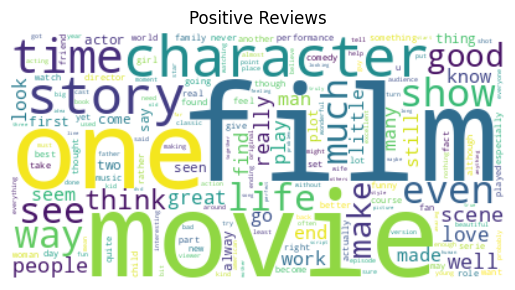

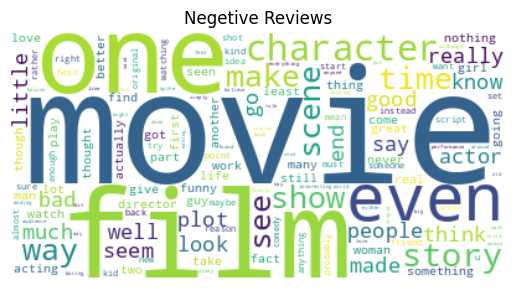

In [6]:
# make input for Word Cloud
text_p = " ".join(train_p.X)
text_n = " ".join(train_n.X)

# plot Word Cloud
my_cloud = WordCloud(background_color='white').generate(text_p)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews")
plt.show()


my_cloud = WordCloud(background_color='white').generate(text_n)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Negetive Reviews")
plt.show()

# 2

.نمودار میله ای تعداد تکرار 30 کلمه اول با بیشترین تکرار یکبار برای تمام کلمات
و یکبار برای متن بدون حروف اضافه رسیم میکنیم اینکار را برای بررسی زیپف انجام میدهیم

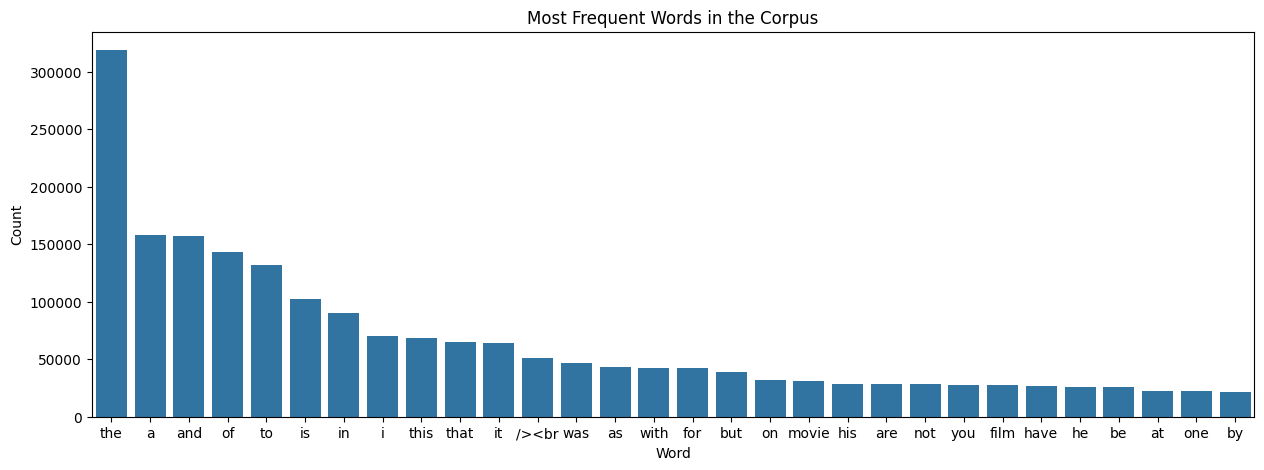

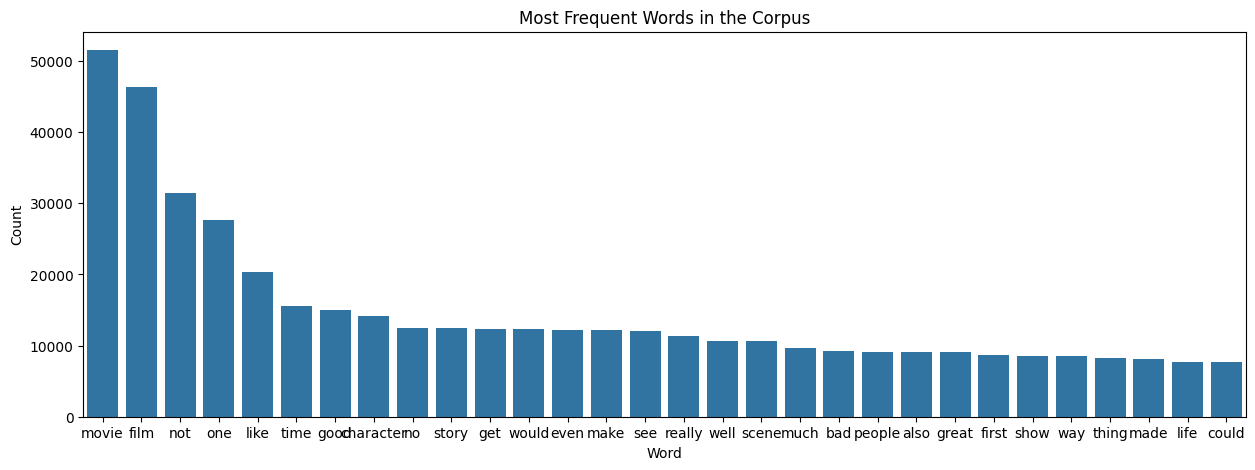

In [7]:
corpus_sw = " ".join(X_train)
corpus_nsw = " ".join(train.X)

def plot_word_frequency(words,top_n=10):
    """Function to plot the word frequencies"""
    word_freq = nltk.FreqDist(words)
    zipdata = pd.DataFrame({"Word":word_freq.keys(), "freq":word_freq.values()})
    zipdata = zipdata.sort_values("freq", ascending= False)
    zipdata["r"] = range(1, len(word_freq.keys()) + 1)
    zipdata["pr"] = zipdata.freq/len(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    plt.figure(figsize=(15,5))
    plt.title("Most Frequent Words in the Corpus")
    plt.ylabel("Count")
    plt.xlabel("Word")
    plot = sns.barplot(x = labels,y = counts)
    return (zipdata, plot)

data1 = plot_word_frequency(corpus_sw.lower().split(), 30)
data2 = plot_word_frequency(corpus_nsw.split(), 30)


حال بار دیگر در شکلی متفاوت قانون زیپف را بررسی میکنیم یکبار لگاریتم رتبه کلمه دربرابر لگاریتم احتمال وبار دیگر رتبه در برابر لگاریتم احتمال را رسم میکنیم در حالت اول خط رسم شده باید یک خط صاف روی قطار باشد و در حالت دوم یک منحنی نزولی با قوس به سمت 0 باشد

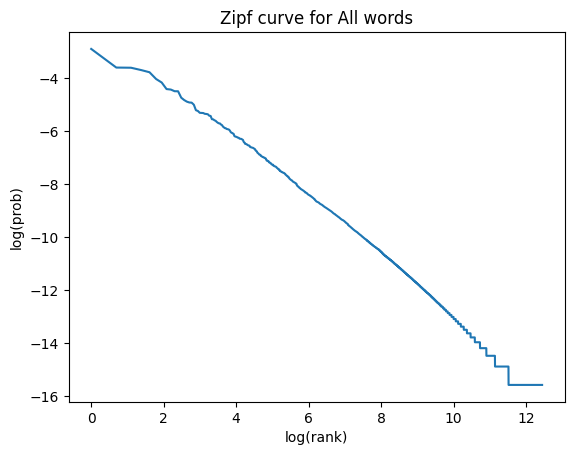

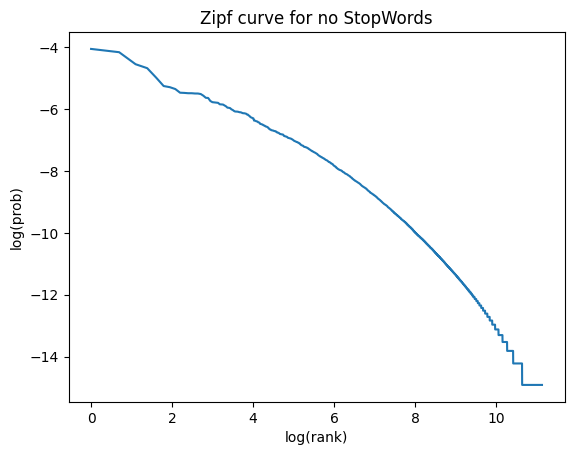

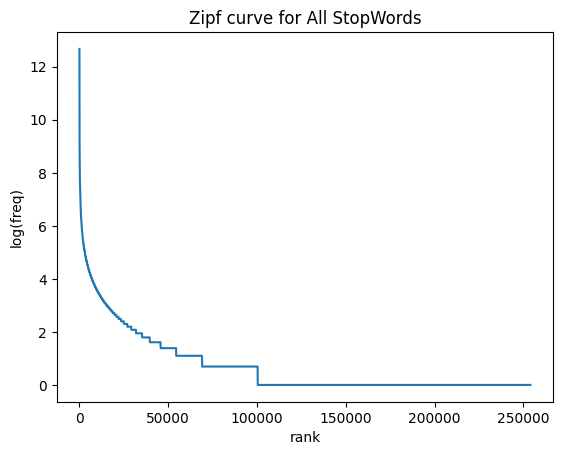

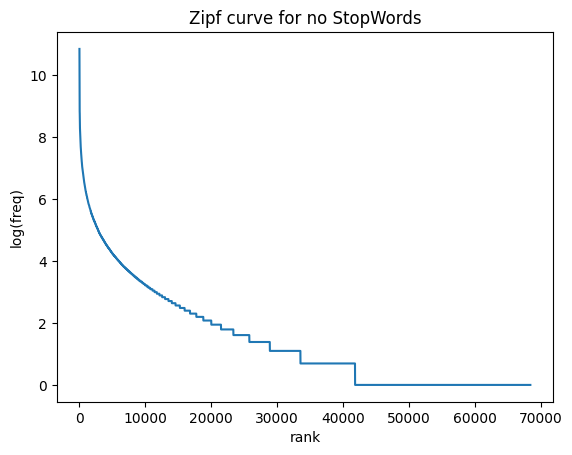

In [8]:
plt.plot(np.log(data1[0].r), np.log(data1[0].pr))
plt.title("Zipf curve for All words")
plt.xlabel("log(rank)")
plt.ylabel("log(prob)")
plt.show()

plt.plot(np.log(data2[0].r), np.log(data2[0].pr))
plt.title("Zipf curve for no StopWords")
plt.xlabel("log(rank)")
plt.ylabel("log(prob)")
plt.show()


plt.plot(data1[0].r, np.log(data1[0].freq))
plt.title("Zipf curve for All StopWords")
plt.xlabel("rank")
plt.ylabel("log(freq)")
plt.show()


plt.plot(data2[0].r, np.log(data2[0].freq))
plt.title("Zipf curve for no StopWords")
plt.xlabel("rank")
plt.ylabel("log(freq)")
plt.show()

# 3

.حال توابع مورد نیاز برای ساخت مدل زبانی تعریف میکنیم و خروجی های مورد نیاز را از آنها دریاف میکنیم

In [9]:
def n_gram_fit(n, tokenized, test, hirac = False, probdist_factory = LaplaceProbDist):
  cfdist = nltk.ConditionalFreqDist()
  if hirac:
    # Tokenize the training data and create N-grams
    for tokens in tokenized:
      for n_ in range(1, n+1):
        for ngram in ngrams(tokens, n_):
            context, token = tuple(ngram[:-1]), ngram[-1]
            cfdist[context][token] += 1
  else:
      # Tokenize the training data and create N-grams
    for tokens in tokenized:
      for ngram in ngrams(tokens, n):
        context, token = tuple(ngram[:-1]), ngram[-1]
        cfdist[context][token] += 1

  mle_model = nltk.probability.ConditionalProbDist(cfdist, probdist_factory, bins = 500000)

  # Function to predict the label of a review
  def predict_label(mle_model, review):
      logprob = 0
      lprob = []
      for i in range(n-1, len(review)):
        context = tuple(review[(i-n+1):(i)])
        token = review[i]
        logprob += (mle_model[context].logprob(token))
        lprob.append(mle_model[context].logprob(token))
      return logprob, lprob
  lab = []
  prob = {}
  for val_sentence in test:
    x = list(pad_both_ends(word_tokenize(val_sentence), n))
    labe, probab = predict_label(mle_model, x)
    lab.append(labe)
    prob[val_sentence] = probab

  return lab, prob

def labeling(pos, neg):
  ls = []
  for i in range(len(pos)):
    if pos[i] >= neg[i]:
      ls.append(1)
    else:
      ls.append(0)
  return ls

def perplex(n, tokenized, test, hirac = False, probdist_factory = LaplaceProbDist):
  _,p = n_gram_fit(n, tokenized, test, hirac , probdist_factory)
  perplex = []
  for probs in list(p.values()):
    leng = len(probs)
    perplex.append(np.exp((-1/leng) * np.sum(probs)))
  return np.mean(perplex)


In [10]:
def n_gram(sequence):
  unigram=[]
  bigram=[]
  trigram=[]
  fourgram=[]
  for ls in sequence:
    for word in ls:
              unigram.append(word)
    bigram.extend(list(ngrams(ls, 2)))
    trigram.extend(list(ngrams(ls, 3)))
    fourgram.extend(list(ngrams(ls, 4)))
  freq_un = nltk.FreqDist(unigram)
  freq_bi = nltk.FreqDist(bigram)
  freq_tri = nltk.FreqDist(trigram)
  freq_four = nltk.FreqDist(fourgram)
  return (unigram,bigram,trigram,fourgram,freq_un,freq_bi,freq_tri,freq_four)


.برای هر کلاس 4 مدل زبانی تشکیل میدهیم

In [11]:
unigram_p,bigram_p,trigram_p,fourgram_p,freq_un_p,freq_bi_p,freq_tri_p,freq_four_p = n_gram(tokenized_p)

unigram_n,bigram_n,trigram_n,fourgram_n,freq_un_n,freq_bi_n,freq_tri_n,freq_four_n = n_gram(tokenized_n)

# 4

.برای هر مدل زبانی 5 تا از پرتکرارترین ترکیب ها با تعداد تکرارشان را نمایش میدهیم

In [12]:
# Positive
print ("\n Most common positive unigrams: ", freq_un_p.most_common(5))
print ("\n Most common positive bigrams: ", freq_bi_p.most_common(5))
print ("\n Most common positive trigrams: ", freq_tri_p.most_common(5))
print ("\n Most common positive fourgrams: ", freq_four_p.most_common(5))

# Negetive
print ("\n Most common Negetive unigrams: ", freq_un_n.most_common(5))
print ("\n Most common Negetive bigrams: ", freq_bi_n.most_common(5))
print ("\n Most common Negetive trigrams: ", freq_tri_n.most_common(5))
print ("\n Most common Negetive fourgrams: ", freq_four_n.most_common(5))


 Most common positive unigrams:  [('film', 24620), ('movie', 22297), ('not', 14747), ('one', 14156), ('like', 9005)]

 Most common positive bigrams:  [(('one', 'best'), 794), (('even', 'though'), 555), (('year', 'old'), 523), (('film', 'not'), 502), (('movie', 'not'), 502)]

 Most common positive trigrams:  [(('movie', 'ever', 'seen'), 112), (('new', 'york', 'city'), 102), (('film', 'ever', 'made'), 90), (('world', 'war', 'ii'), 72), (('one', 'best', 'film'), 71)]

 Most common positive fourgrams:  [(('best', 'movie', 'ever', 'seen'), 19), (('movie', 'seen', 'long', 'time'), 19), (('funniest', 'movie', 'ever', 'seen'), 18), (('vote', 'eight', 'title', 'brazil'), 17), (('one', 'best', 'movie', 'ever'), 16)]

 Most common Negetive unigrams:  [('movie', 29251), ('film', 21747), ('not', 16715), ('one', 13519), ('like', 11322)]

 Most common Negetive bigrams:  [(('look', 'like'), 1104), (('ever', 'seen'), 900), (('special', 'effect'), 755), (('not', 'even'), 737), (('movie', 'not'), 717)]


# 5

.معیار پرپلکیسیتی را برای داده های آزمایشی با استفاده از مدل مربوط به حود محاسبه میکنیم در اینجا از هموارسازی لاپلاس استفاده شده است

In [13]:
# positive perplexity

# unigram
print("positive val data perplexity for unigram", perplex(1, tokenized_p, val_p.X))

# bigram
print("positive val data perplexity for bigram", perplex(2, tokenized_p, val_p.X))

# trigram
print("positive val data perplexity for trigram", perplex(3, tokenized_p, val_p.X))

# fourgram
print("positive val data perplexity for fourgram", perplex(4, tokenized_p, val_p.X))


# negetive perplexity

# unigram
print("negetive val data perplexity for unigram", perplex(1, tokenized_n, val_n.X))

# bigram
print("negetive val data perplexity for bigram", perplex(2, tokenized_n, val_n.X))

# trigram
print("negetive val data perplexity for trigram", perplex(3, tokenized_n, val_n.X))

# fourgram
print("negetive val data perplexity for fourgram", perplex(4, tokenized_n, val_n.X))


positive val data perplexity for unigram 259006.56674274558
positive val data perplexity for bigram 39298435.66101037
positive val data perplexity for trigram 147878216.23771137
positive val data perplexity for fourgram 164638080.90602988
negetive val data perplexity for unigram 232489.13542019384
negetive val data perplexity for bigram 35863688.99276271
negetive val data perplexity for trigram 143487803.25228757
negetive val data perplexity for fourgram 162692407.00726476


.در این قسمت معیار پرپکسیتی برای هموارسازی درستنمایی مورد انتظار محاسبه میکنیم

In [14]:
# positive perplexity

# unigram
print("positive val data perplexity for unigram", perplex(1, tokenized_p, val_p.X, probdist_factory = ELEProbDist))

# bigram
print("positive val data perplexity for bigram", perplex(2, tokenized_p, val_p.X, probdist_factory = ELEProbDist))

# trigram
print("positive val data perplexity for trigram", perplex(3, tokenized_p, val_p.X, probdist_factory = ELEProbDist))

# fourgram
print("positive val data perplexity for fourgram", perplex(4, tokenized_p, val_p.X, probdist_factory = ELEProbDist))


# negetive perplexity

# unigram
print("negetive val data perplexity for unigram", perplex(1, tokenized_n, val_n.X, probdist_factory = ELEProbDist))

# bigram
print("negetive val data perplexity for bigram", perplex(2, tokenized_n, val_n.X, probdist_factory = ELEProbDist))

# trigram
print("negetive val data perplexity for trigram", perplex(3, tokenized_n, val_n.X, probdist_factory = ELEProbDist))

# fourgram
print("negetive val data perplexity for fourgram", perplex(4, tokenized_n, val_n.X, probdist_factory = ELEProbDist))


positive val data perplexity for unigram 223220.32449697432
positive val data perplexity for bigram 27659285.460289843
positive val data perplexity for trigram 141308158.0883136
positive val data perplexity for fourgram 163800740.57030302
negetive val data perplexity for unigram 200118.1314668945
negetive val data perplexity for bigram 25075709.612033453
negetive val data perplexity for trigram 136240916.73925778
negetive val data perplexity for fourgram 161415663.9527144


# 6

حال برای هر کلاس با استفاده از داده های آزمایشی احتمالات را محاسبه میکنیم و برای هر متن در داده کلاس را با توجه به احتمال بزرگتر پیشبینی میکنیم تا بتوان دقت هر مدل را محاسبه کرد هموارسازی نیز لاپلاس است.

In [15]:
# unigram
pos,_ = n_gram_fit(1, tokenized_p,val.X)
neg,_ = n_gram_fit(1, tokenized_n,val.X)
pred = labeling(pos, neg)
print("unigram model accuracy", accuracy_score(val.y, pred), "\n")

# bigram
pos,_ = n_gram_fit(2, tokenized_p,val.X)
neg,_ = n_gram_fit(2, tokenized_n,val.X)
pred = labeling(pos, neg)
print("bigram model accuracy", accuracy_score(val.y, pred), "\n")

# trigram
pos,_ = n_gram_fit(3, tokenized_p,val.X)
neg,_ = n_gram_fit(3, tokenized_n,val.X)
pred = labeling(pos, neg)
print("trigram model accuracy", accuracy_score(val.y, pred), "\n")

# fourgram
pos,_ = n_gram_fit(4, tokenized_p,val.X)
neg,_ = n_gram_fit(4, tokenized_n,val.X)
pred = labeling(pos, neg)
print("fourgram model accuracy", accuracy_score(val.y, pred), "\n")


unigram model accuracy 0.85408 

bigram model accuracy 0.88072 

trigram model accuracy 0.78088 

fourgram model accuracy 0.50584 



.دقت مدل برای همواراسازی درستنمایی نیز محاسبه شده است

In [16]:
# unigram
pos,_ = n_gram_fit(1, tokenized_p,val.X, probdist_factory = ELEProbDist)
neg,_ = n_gram_fit(1, tokenized_n,val.X, probdist_factory = ELEProbDist)
pred = labeling(pos, neg)
print("unigram model accuracy", accuracy_score(val.y, pred), "\n")

# bigram
pos,_ = n_gram_fit(2, tokenized_p,val.X, probdist_factory = ELEProbDist)
neg,_ = n_gram_fit(2, tokenized_n,val.X, probdist_factory = ELEProbDist)
pred = labeling(pos, neg)
print("bigram model accuracy", accuracy_score(val.y, pred), "\n")

# trigram
pos,_ = n_gram_fit(3, tokenized_p,val.X, probdist_factory = ELEProbDist)
neg,_ = n_gram_fit(3, tokenized_n,val.X, probdist_factory = ELEProbDist)
pred = labeling(pos, neg)
print("trigram model accuracy", accuracy_score(val.y, pred), "\n")

# fourgram
pos,_ = n_gram_fit(4, tokenized_p,val.X, probdist_factory = ELEProbDist)
neg,_ = n_gram_fit(4, tokenized_n,val.X, probdist_factory = ELEProbDist)
pred = labeling(pos, neg)
print("fourgram model accuracy", accuracy_score(val.y, pred), "\n")


unigram model accuracy 0.85368 

bigram model accuracy 0.87752 

trigram model accuracy 0.78 

fourgram model accuracy 0.50608 



.محاسبه دقت هر مدل برای داده آموزشی برای مشاهده بیش برازش مدل

In [17]:
# unigram
pos,_ = n_gram_fit(1, tokenized_p,train.X)
neg,_ = n_gram_fit(1, tokenized_n,train.X)
pred = labeling(pos, neg)
print("unigram train model accuracy", accuracy_score(train.y, pred), "\n")

# bigram
pos,_ = n_gram_fit(2, tokenized_p,train.X)
neg,_ = n_gram_fit(2, tokenized_n,train.X)
pred = labeling(pos, neg)
print("bigram train model accuracy", accuracy_score(train.y, pred), "\n")

# trigram
pos,_ = n_gram_fit(3, tokenized_p,train.X)
neg,_ = n_gram_fit(3, tokenized_n,train.X)
pred = labeling(pos, neg)
print("trigram train model accuracy", accuracy_score(train.y, pred), "\n")

# fourgram
pos,_ = n_gram_fit(4, tokenized_p,train.X)
neg,_ = n_gram_fit(4, tokenized_n,train.X)
pred = labeling(pos, neg)
print("fourgram train model accuracy", accuracy_score(train.y, pred), "\n")


unigram train model accuracy 0.91136 

bigram train model accuracy 0.9996 

trigram train model accuracy 1.0 

fourgram train model accuracy 0.99996 



# 7

با توجه به دقت مدل های قبل بهترین مدل را انتخاب کرده و پیشبینی را انجام میدهیم.

In [18]:
# prediction

test_p, _ = n_gram_fit(2, tokenized_p, test.X)
test_n, _ = n_gram_fit(2, tokenized_n, test.X)

test_pred = labeling(test_p, test_n)

.کلاس های پیشبینی شده را در یک فایل ذخیره میکنیم

In [19]:
with  open("y_test.txt", "w") as f:
  for i in test_pred:
    f.write(str(i))
    f.write("\n")
  f.close()